In [1]:
!*go mod edit -replace github.com/gomlx/gomlx=/opt/janpf/Projects/gomlx.gomlx

In [4]:
import (
    "log"
    "path"

    "github.com/gomlx/gomlx/ml/data"
    "github.com/gomlx/gomlx/models/inceptionv3"
)

var (
    flagDataDir = flag.String("data", "~/work/inceptionv3", "Directory to save and load downloaded and generated dataset files.")
)

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Error: %+v\n", err)
    }
}

const (
    BaselineImage = "logo.png"
)

%%
err := inceptionv3.DownloadAndUnpackWeights(*flagDataDir)
AssertNoError(err)

In [7]:
import (
        "github.com/gomlx/gomlx/models/inceptionv3"
)

%%
name := "batch_normalization_7/batch_normalization_7/beta:0"
fPath := inceptionv3.PathToTensor(*flagDataDir, name)
f, err := os.Open(fPath)
AssertNoError(err)

local, err := tensor.Load(f)
AssertNoError(err)
fmt.Printf("%s: shape %s, values=%s\n", name, local.Shape(), local)

batch_normalization_7/batch_normalization_7/beta:0: shape (Float32)[48], values=(Float32)[48]: [0.60545784 0.5561335 -0.3865367 1.0141947 1.8168011 -0.14041665 -0.20392203 0.49767718 -0.024301322 -0.62525994 1.250498 1.0262886 -0.21821642 -0.21507807 1.6200733 0.38839766 1.7593417 1.7387105 -0.0854155 1.7372131 1.6305265 -0.21300565 0.61412483 -0.32287326 0.9382342 0.8768287 0.8632834 0.15885311 0.04726633 0.2727267 -0.046138786 -0.20415373 -0.13442904 0.64326024 0.49279115 -0.053494237 -0.34507582 0.0011138958 0.8811501 1.7704751 0.49408326 0.22983034 0.2610325 -0.33718777 0.7270833 0.541416 -0.1553545 -0.23224317]


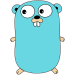

In [15]:
import (
    "image"
    _ "image/png"
    
    "github.com/janpfeifer/gonb/gonbui"
)

func LoadImage(filePath string) (img image.Image, err error) {    
    imgFile, err := os.Open(filePath)
    if err != nil {
        return
    }
    defer imgFile.Close()

    img, _, err = image.Decode(imgFile)
    return
}

func LoadLogo() (img image.Image, err error) {    
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    logoPath := path.Join(*flagDataDir, BaselineImage)
    return LoadImage(logoPath)
}

%%
img, err := LoadLogo()
AssertNoError(err)
gonbui.DisplayImage(img)

imgT.Shape()=(Float32)[75 75 3]
	max=1, min=0


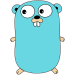

In [28]:
import (
    "github.com/gomlx/gomlx/types/shapes"
    . "github.com/gomlx/gomlx/graph"
    timage "github.com/gomlx/gomlx/types/tensor/image"
)
%%
manager := BuildManager().MustDone()
img, err := LoadLogo()
AssertNoError(err)

imgT := timage.ToTensor(shapes.F32).Single(img)
fmt.Printf("imgT.Shape()=%v\n", imgT.Shape())
takeMax := NewExec(manager, func(x *Node) (*Node, *Node) {
    return ReduceAllMax(x), Neg(ReduceAllMax(Neg(x)))
})
res, err := takeMax.Call(imgT)
AssertNoError(err)
fmt.Printf("\tmax=%v, min=%v\n", res[0].Value(), res[1].Value())

img2, err := timage.ToImage().Single(imgT)
AssertNoError(err)
gonbui.DisplayImage(img2)